In [2]:
# %pip install nltk wordcloud
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns  
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder

# Cleaning

In [3]:
df = pd.read_csv('/Users/karangautam/Desktop/ppro/amazon/Electronics_sample_300k.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewTime  300000 non-null  object 
 1   reviewText  299933 non-null  object 
 2   summary     299962 non-null  object 
 3   asin        300000 non-null  object 
 4   reviewerID  300000 non-null  object 
 5   overall     300000 non-null  float64
dtypes: float64(1), object(5)
memory usage: 13.7+ MB


In [5]:
df.duplicated().sum()

227

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(299773, 6)

In [8]:
def check(val):
    if val <= 2:
        return 'Negative'
    elif val == 3:
        return 'Neutral'
    else:
        return 'Positive'

In [9]:
df['sentiment'] = df['overall'].apply(check)

In [10]:
df.isna().sum()

reviewTime     0
reviewText    67
summary       38
asin           0
reviewerID     0
overall        0
sentiment      0
dtype: int64

In [11]:
df.dropna(subset=['reviewText','summary'], inplace=True, axis=0)

In [12]:
df['sentiment'].value_counts() / len(df) * 100

sentiment
Positive    79.050886
Negative    13.946388
Neutral      7.002726
Name: count, dtype: float64

In [13]:
df.shape

(299669, 7)

In [14]:
df.rename(columns={'reviewText': 'review_text', 'summary': 'review_summary', 'reviewerID': 'reviewer_id', 'asin': 'product_id', 'reviewTime': 'review_time'}, inplace=True)

In [15]:
df['review_time'] = pd.to_datetime(df['review_time'], format='%m %d, %Y')

In [16]:
df.drop(columns=['overall','reviewer_id','product_id','review_time'], axis=1, inplace=True)

In [17]:
df.head()

,review_text,review_summary,sentiment
0,This was the first time I read Garcia-Aguilera...,Hit The Spot!,Positive
1,"As with all of Ms. Garcia-Aguilera's books, I ...",one hot summer is HOT HOT HOT!,Positive
2,I've not read any of Ms Aguilera's works befor...,One Hot Summer,Positive
3,This romance novel is right up there with the ...,I love this book!,Positive
4,Carolina Garcia Aguilera has done it again. S...,One Hot Book,Positive


In [18]:
LabelEncoder = LabelEncoder()
df['sentiment'] = LabelEncoder.fit_transform(df['sentiment'])

In [19]:
df['review_text'] = df['review_summary'].str.lower() + " " + df['review_text'].str.lower()
df.drop(columns=['review_summary'], axis=1, inplace=True)

In [20]:
df.sample()

,review_text,sentiment
95015,good buy this product was a good buy very plea...,2


In [21]:
df.shape

(299669, 2)

In [22]:
df['sentiment'].skew()

-1.7036657468982952

In [23]:
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [24]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    ps = PorterStemmer()
    
    for i in text:
        y.append(ps.stem(i))

    return " ".join(y) 

# EDA


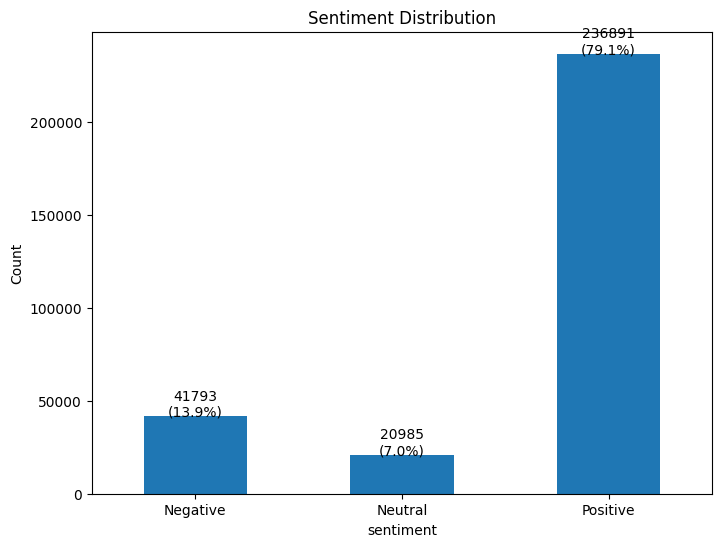

In [25]:
sentiment_counts = df['sentiment'].value_counts().sort_index()
percentages = sentiment_counts / sentiment_counts.sum() * 100

ax = sentiment_counts.plot(kind='bar', figsize=(8, 6))

for i, v in enumerate(sentiment_counts):
    ax.text(i, v, f'{v}\n({percentages[i]:.1f}%)', ha='center')

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)
ax.set_title('Sentiment Distribution')
ax.set_ylabel('Count')
plt.show()


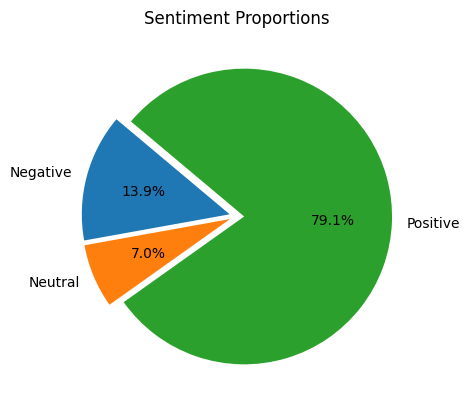

In [26]:
sentiment_counts = df['sentiment'].value_counts().sort_index()
plt.pie(
    sentiment_counts,
    labels=['Negative', 'Neutral', 'Positive'],
    autopct='%1.1f%%',
    startangle=140,
    explode=(0.05, 0.05, 0.05)
)
plt.title('Sentiment Proportions')
plt.show()


In [27]:
per = df['sentiment'].value_counts() * 100 / len(df)

dict = {'Sentiment': ['Negative', 'Neutral', 'Positive'], 'Count': sentiment_counts, 'Percentage': per}
pd.DataFrame(dict)

,Sentiment,Count,Percentage
sentiment,,,
0,Negative,41793,13.946388
1,Neutral,20985,7.002726
2,Positive,236891,79.050886


In [28]:
df['num_words'] = df['review_text'].apply(lambda x: len(x.split()))
df['num_chars'] = df['review_text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['review_text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [29]:
df.sample()

,review_text,sentiment,num_words,num_chars,num_sentences
270985,best quality- worth the extra tiny bit of cash...,2,76,84,6


In [30]:
df[df['sentiment'] == 0][['num_words','num_chars','num_sentences']].describe()

,num_words,num_chars,num_sentences
count,41793.000000,41793.000000,41793.000000
mean,80.239251,91.887493,5.382241
std,86.620831,99.666447,5.010108
min,2.000000,2.000000,1.000000
25%,29.000000,33.000000,2.000000
50%,55.000000,62.000000,4.000000
75%,103.000000,118.000000,7.000000
max,1962.000000,2246.000000,112.000000


In [31]:
df[df['sentiment'] == 1][['num_words','num_chars','num_sentences']].describe()

,num_words,num_chars,num_sentences
count,20985.000000,20985.000000,20985.000000
mean,85.408959,97.649464,5.264665
std,107.068127,123.765565,6.003724
min,2.000000,2.000000,1.000000
25%,26.000000,29.000000,2.000000
50%,51.000000,58.000000,3.000000
75%,106.000000,121.000000,6.000000
max,3596.000000,4279.000000,234.000000


In [32]:
df[df['sentiment'] == 2][['num_words','num_chars','num_sentences']].describe()

,num_words,num_chars,num_sentences
count,236891.000000,236891.000000,236891.000000
mean,64.436344,73.693661,4.476097
std,93.566584,107.834837,5.159002
min,2.000000,2.000000,1.000000
25%,15.000000,17.000000,2.000000
50%,34.000000,39.000000,3.000000
75%,75.000000,86.000000,5.000000
max,3626.000000,4122.000000,204.000000


<Axes: xlabel='num_words', ylabel='Count'>

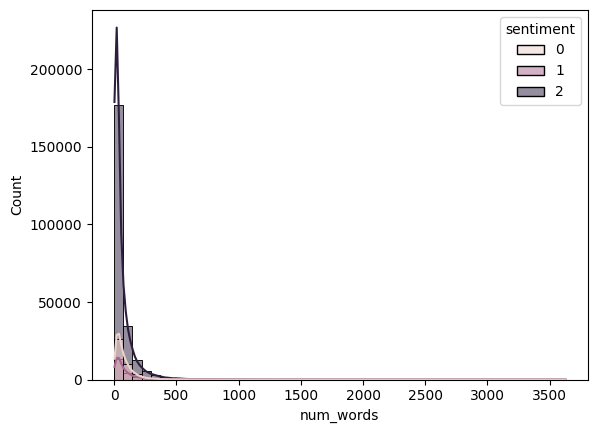

In [33]:
sns.histplot(data=df, x='num_words', hue='sentiment', bins=50, kde=True)

<Axes: xlabel='num_chars', ylabel='Count'>

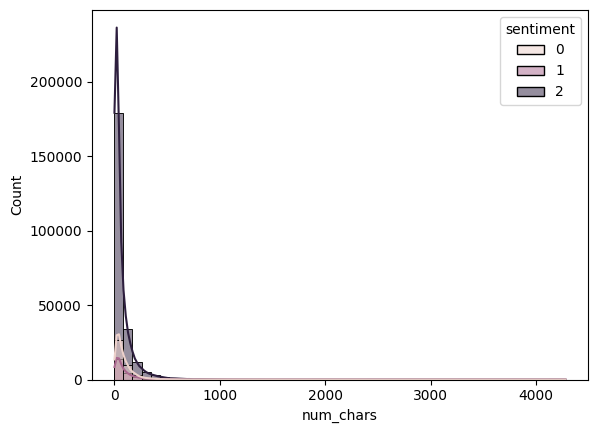

In [34]:
sns.histplot(data=df, x='num_chars', hue='sentiment', bins=50, kde=True)

<Axes: xlabel='num_sentences', ylabel='Count'>

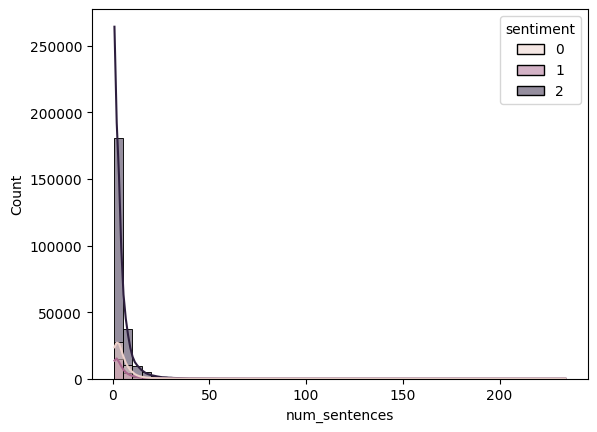

In [35]:
sns.histplot(data=df, x='num_sentences', hue='sentiment', bins=50, kde=True)

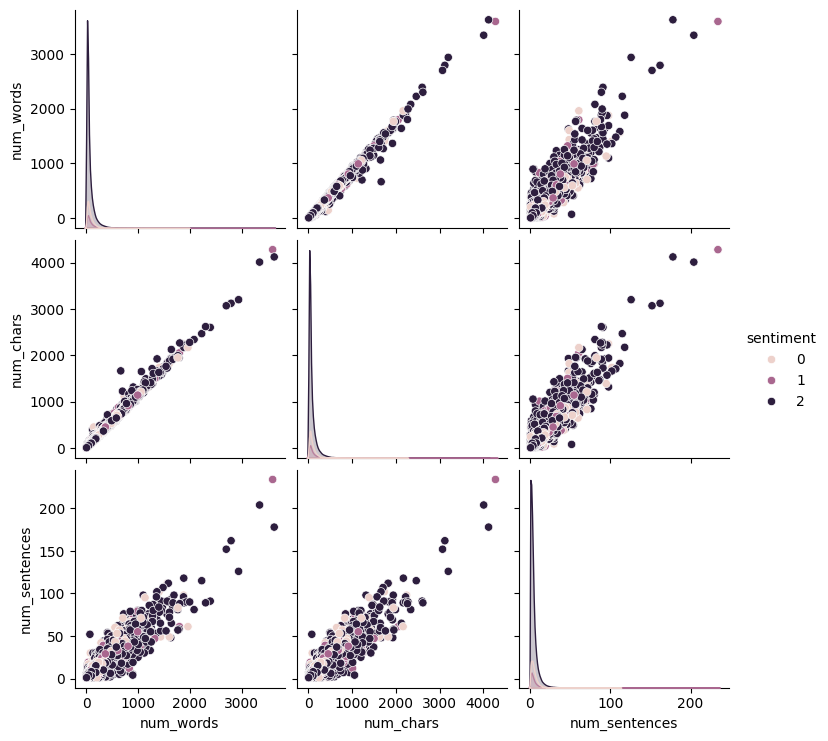

In [36]:
sns.pairplot(df, hue='sentiment')

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'sentiment'),
  Text(0, 1.5, 'num_words'),
  Text(0, 2.5, 'num_chars'),
  Text(0, 3.5, 'num_sentences')])

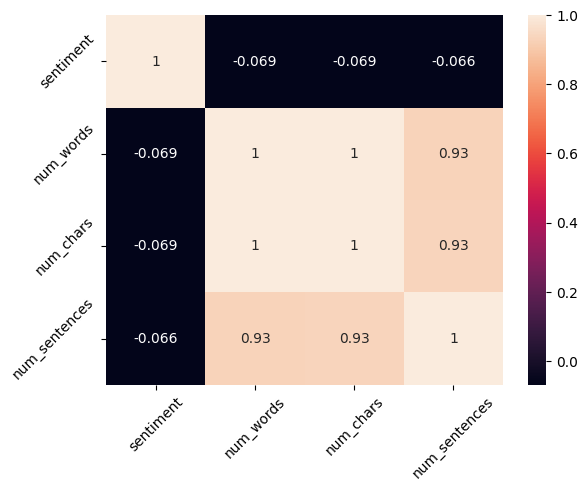

In [37]:
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

In [38]:
def transform_text(text):
    text = text.lower()
    

    words = re.findall(r'\b[a-z]+\b', text)
    
    stop_words = set(stopwords.words('english'))
    
    words = [word for word in words if word not in stop_words]
    
    return " ".join(words)

In [39]:
negative_reviews = df[df['sentiment'] == 0]['review_text'].apply(transform_text)

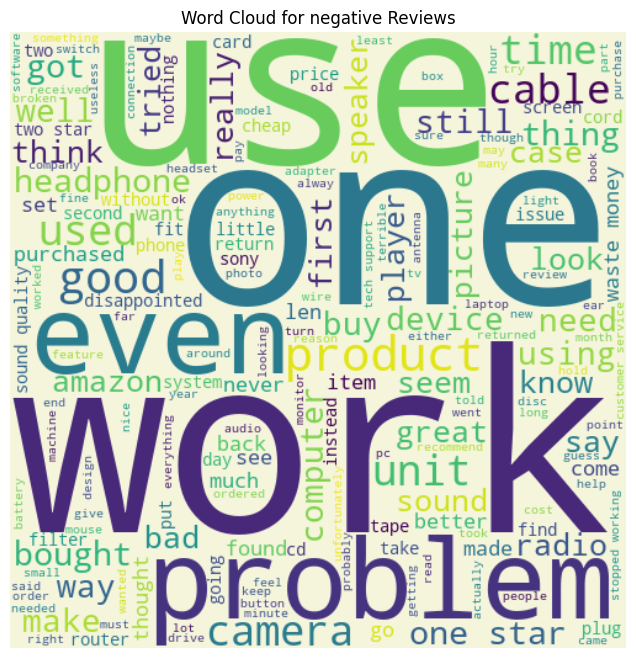

In [40]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='beige')
negative_wc = wc.generate(' '.join(negative_reviews))
plt.figure(figsize=(8, 8))
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for negative Reviews')
plt.show()

In [41]:
neutral_reviews = df[df['sentiment'] == 1]['review_text'].apply(transform_text)

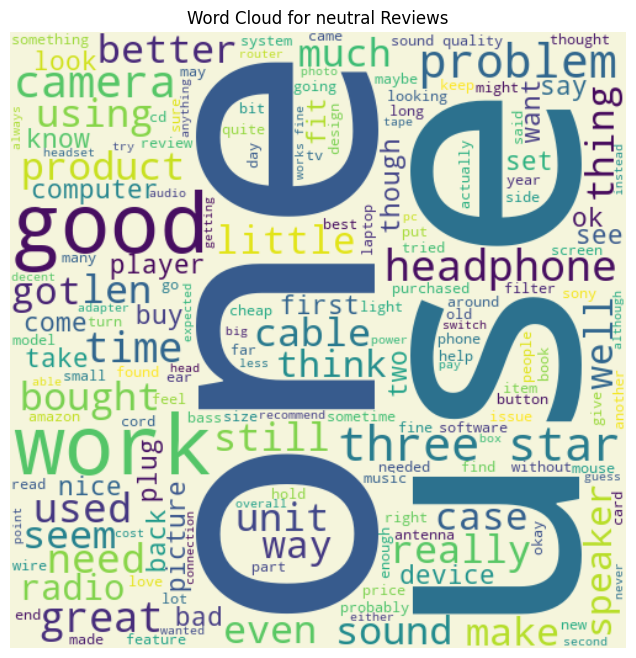

In [42]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='beige')
neutral_wc = wc.generate(' '.join(neutral_reviews))
plt.figure(figsize=(8, 8))
plt.imshow(neutral_wc, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud for neutral Reviews')
plt.show()

In [43]:
positive_reviews = df[df['sentiment'] == 2]['review_text'].apply(transform_text)

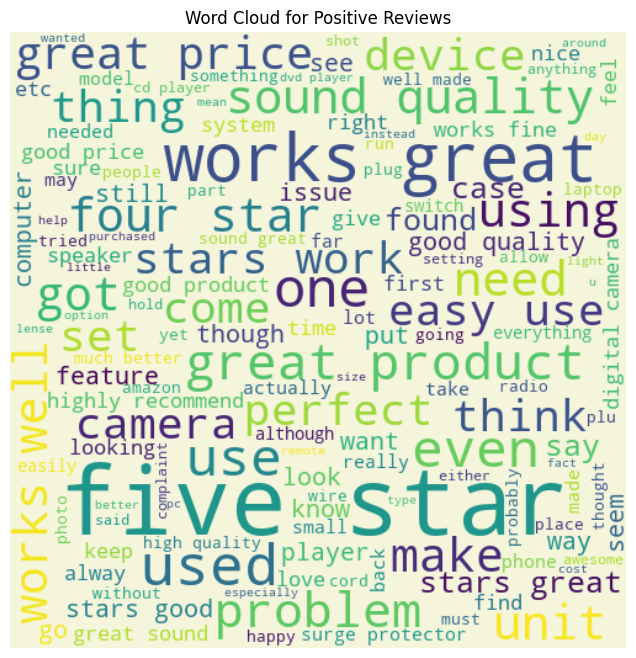

In [44]:
positive_wc = wc.generate(' '.join(positive_reviews))
plt.figure(figsize=(8, 8))
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

In [45]:
positive_corpus = []

for review in positive_reviews:
    for word in review.split():
        positive_corpus.append(word)
        
positive_word_counts = Counter(positive_corpus)
most_common_positive_words = positive_word_counts.most_common(30)

In [46]:
most_common_positive_words_df = pd.DataFrame(most_common_positive_words, columns=['Word', 'Count'])

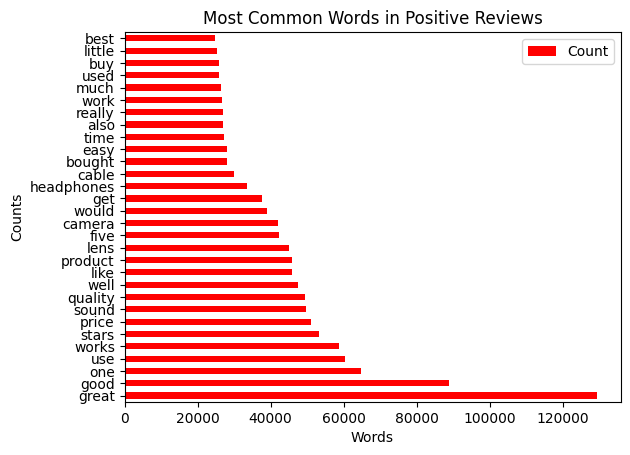

In [47]:
most_common_positive_words_df.plot.barh(x='Word', y='Count',color='red')

plt.title('Most Common Words in Positive Reviews')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()  

In [48]:
negative_corpus = []

for review in negative_reviews:
    for word in review.split():
        negative_corpus.append(word)
        
negative_word_counts = Counter(negative_corpus)
most_common_negative_words = negative_word_counts.most_common(30)

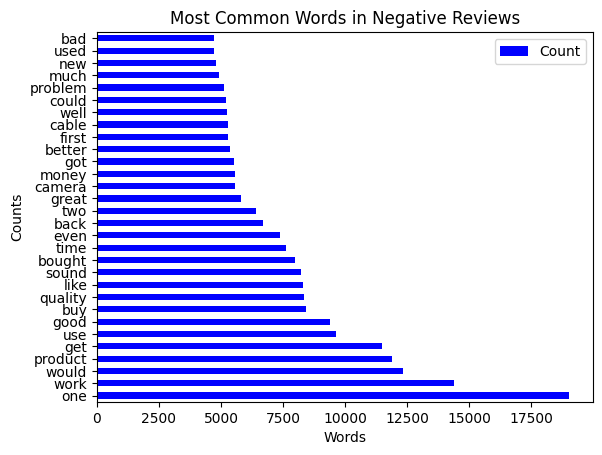

In [49]:
most_common_negative_words_df = pd.DataFrame(most_common_negative_words, columns=['Word', 'Count'])
most_common_negative_words_df.plot.barh(x='Word', y='Count', color='blue')
plt.title('Most Common Words in Negative Reviews')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

In [50]:
neutral_corpus = []

for review in neutral_reviews:
    for word in review.split():
        neutral_corpus.append(word)
        
neutral_word_counts = Counter(neutral_corpus)
most_common_neutral_words = neutral_word_counts.most_common(30)

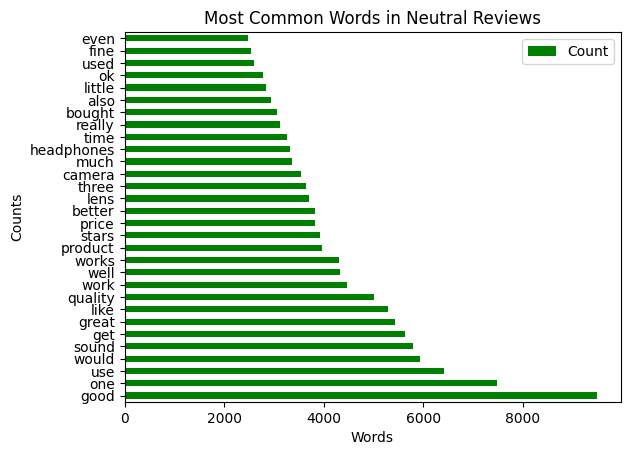

In [51]:
most_common_neutral_words_df = pd.DataFrame(most_common_neutral_words, columns=['Word', 'Count'])
most_common_neutral_words_df.plot.barh(x='Word', y='Count', color='green')
plt.title('Most Common Words in Neutral Reviews')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

Violin Plots: Text Metrics Distribution by Sentiment

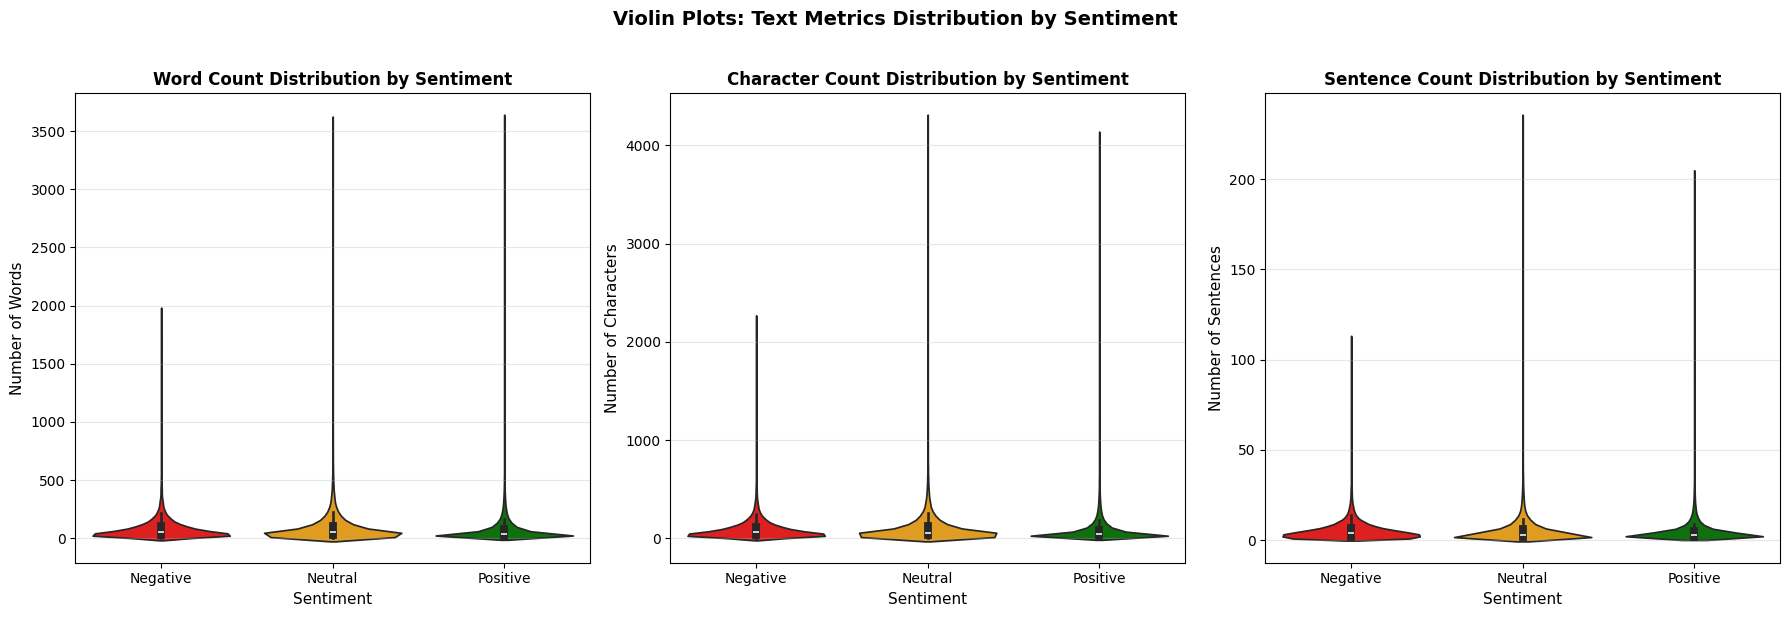

In [52]:
# Violin Plots: All Three Metrics in One Subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['red', 'orange', 'green']


#  words
sns.violinplot(x='sentiment', y='num_words', data=df, palette=colors, ax=axes[0])
axes[0].set_xticklabels(['Negative', 'Neutral', 'Positive'])
axes[0].set_title('Word Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=11)
axes[0].set_ylabel('Number of Words', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

#  characters
sns.violinplot(x='sentiment', y='num_chars', data=df, palette=colors, ax=axes[1])
axes[1].set_xticklabels(['Negative', 'Neutral', 'Positive'])
axes[1].set_title('Character Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sentiment', fontsize=11)
axes[1].set_ylabel('Number of Characters', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

#  sentences
sns.violinplot(x='sentiment', y='num_sentences', data=df, palette=colors, ax=axes[2])
axes[2].set_xticklabels(['Negative', 'Neutral', 'Positive'])
axes[2].set_title('Sentence Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Sentiment', fontsize=11)
axes[2].set_ylabel('Number of Sentences', fontsize=11)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Violin Plots: Text Metrics Distribution by Sentiment', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Box Plots for All Metrics Side by Side

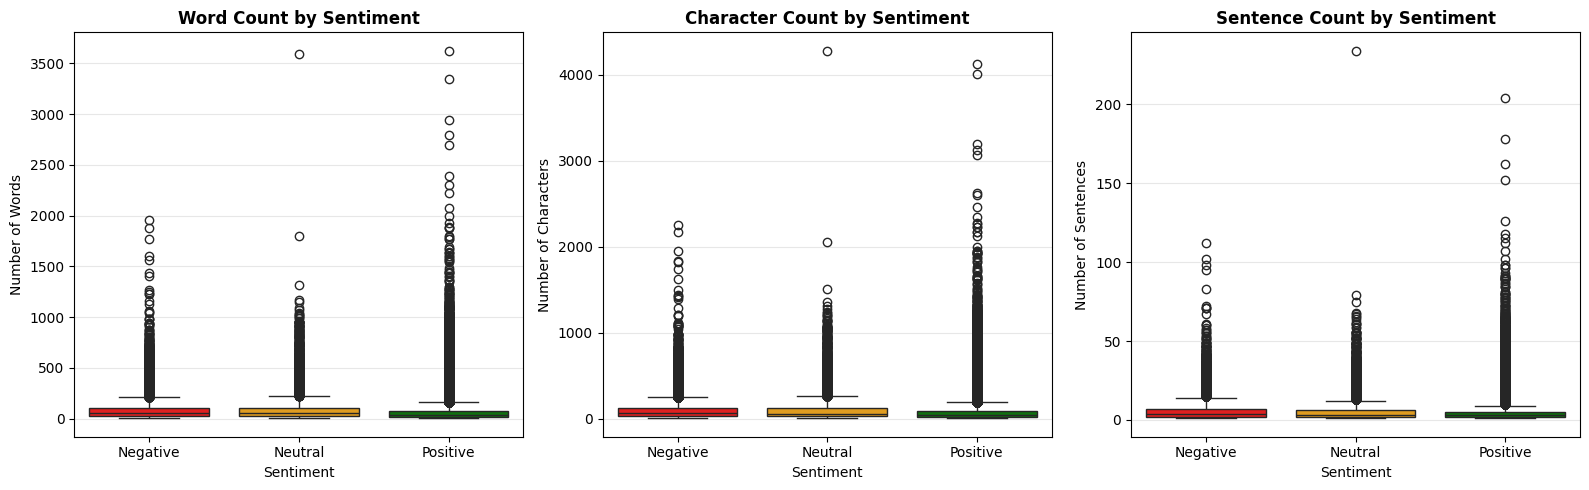

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['red', 'orange', 'green']

# of words
sns.boxplot(x='sentiment', y='num_words', data=df, palette=colors, ax=axes[0])
axes[0].set_xticklabels(['Negative', 'Neutral', 'Positive'])
axes[0].set_title('Word Count by Sentiment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Number of Words')
axes[0].grid(axis='y', alpha=0.3)

# characters
sns.boxplot(x='sentiment', y='num_chars', data=df, palette=colors, ax=axes[1])
axes[1].set_xticklabels(['Negative', 'Neutral', 'Positive'])
axes[1].set_title('Character Count by Sentiment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Number of Characters')
axes[1].grid(axis='y', alpha=0.3)

# sentences
sns.boxplot(x='sentiment', y='num_sentences', data=df, palette=colors, ax=axes[2])
axes[2].set_xticklabels(['Negative', 'Neutral', 'Positive'])
axes[2].set_title('Sentence Count by Sentiment', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Sentiment')
axes[2].set_ylabel('Number of Sentences')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()